In [1]:
import os.path as os

import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.datasets import ModelNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MLP, Linear, PointNetConv, fps, global_max_pool, radius
from torch_geometric.typing import WITH_TORCH_CLUSTER

if not WITH_TORCH_CLUSTER:
    quit("This example requires 'torch-cluster'")
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# data set imports
import dataset_utils as du
from torch.utils.data import DataLoader, random_split

B = 1 

# load dataset
dataset = du.SDFDataset("./cars995")
train_percent = 0.002

# split dataset into training and validation sets
train_size = int(train_percent * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=B, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train dataset size: {len(train_dataset)}, Validation dataset size: {len(val_dataset)}")

Train dataset size: 1, Validation dataset size: 994


/home/cpsc452_lrk42/.conda/envs/basenv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
def process_batch(batch, np_in=2048, np_q=15000):
    B, N, _ = batch.shape
    assert B == 1, "Batch size must be 1 for now."
    
    # # use surface points
    # surface_points = batch[batch[:, :, 3] == 0]
    idx = torch.randperm(N)[:np_in]
    pos = batch[:, idx, :3] # input positions (B, N, 3) -> (N, 3) # this is what fps expects
    x = batch[0, idx, 3].unsqueeze(-1)
    
    idx = torch.randperm(N)[:np_q]
    query_pos = batch[:, idx, :3] # query positions
    query_sdf = batch[:, idx, 3] # SDF values
    
    batch_vec = torch.zeros(np_in, dtype=torch.long) # batch vector for input points
    
    return x.to(device), pos.contiguous().squeeze(0).to(device), batch_vec.contiguous().squeeze(0).to(device), query_pos.squeeze(0).to(device), query_sdf.squeeze(0).to(device)

Define Layers and Model

In [ ]:
class SAModule(torch.nn.Module):
    def __init__(self, ratio, r, nn):
        super().__init__()
        self.ratio = ratio
        self.r = r
        self.conv = PointNetConv(nn, add_self_loops=False)

    def forward(self, x, pos, batch):
        idx = fps(pos, batch, ratio=self.ratio)
        row, col = radius(pos, pos[idx], self.r, batch, batch[idx],
                          max_num_neighbors=128)
        edge_index = torch.stack([col, row], dim=0)
        x_dst = None if x is None else x[idx]
        x = self.conv((x, x_dst), (pos, pos[idx]), edge_index)
        pos, batch = pos[idx], batch[idx]
        return x, pos, batch


class GlobalSAModule(torch.nn.Module):
    def __init__(self, nn):
        super().__init__()
        self.nn = nn

    def forward(self, x, pos, batch):
        x = self.nn(torch.cat([x, pos], dim=1))
        x = global_max_pool(x, batch)
        pos = pos.new_zeros((x.size(0), 3))
        batch = torch.arange(x.size(0), device=batch.device)
        return x, pos, batch


class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Input channels account for both `pos` and node features.
        self.sa1_module = SAModule(0.5, 0.2, MLP([4, 64, 64, 128]))
        self.sa2_module = SAModule(0.25, 0.5, MLP([128 + 3, 128, 128, 256]))
        self.sa3_module = GlobalSAModule(MLP([256 + 3, 256, 512, 1024]))

        self.mlp_mu = MLP([1024, 512], dropout=0.4, norm=None) # get mu
        self.mlp_logvar = MLP([1024, 512], dropout=0.4, norm=None) # get logvar

        self.query = MLP([512 + 3, 256, 128], dropout=0.4, norm=None) 
        self.sdf = Linear(128, 1)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std) # std just gives dimension of tensor to give back
        return mu + epsilon * std

    def forward(self, x, pos, batch, query_pos):
        # encode shape
        sa0_out = (x, pos, batch)
        sa1_out = self.sa1_module(*sa0_out)
        sa2_out = self.sa2_module(*sa1_out)
        sa3_out = self.sa3_module(*sa2_out)
        x, pos, batch = sa3_out # x latent encoding from pointnet
        
        # vae
        mu = self.mlp_mu(x)
        logvar = self.mlp_logvar(x)
        x = self.reparametrize(mu, logvar) # latent sampled vector z=x
        
        # decoder
        x = torch.cat((x.squeeze(0).repeat(query_pos.shape[0], 1), query_pos), dim=-1) # concatenate encoded shape with query positions

        return self.sdf(x) -0.1, mu, logvar #! added mean offset of -0.1

Define Loss

In [15]:
def loss_function(out, query_sdf, mu, logvar):
    mse_loss = F.mse_loss(out, query_sdf)  # L2 loss for SDF prediction
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # KL Divergence loss for latent distribution

    return mse_loss + 0.01 * kl_loss

In [21]:
# test model
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch = next(iter(train_loader))
print(f'Batch shape: {batch.shape}')
x, pos, batch, query_pos, query_sdf = process_batch(batch)
print(f'pos shape: {pos.shape}, query_pos shape: {query_pos.shape}, query_sdf shape: {query_sdf.shape}, x shape: {x.shape}')

print(f'pos shape: {pos.shape}')
# forward pass
output, mu, logvar = model(x, pos, batch, query_pos)
# print output shape
print(f"Output shape: {output.shape}")

loss = loss_function(output.squeeze(-1), query_sdf, mu, logvar)
print(f'Loss: {loss.item()}')

/home/cpsc452_lrk42/.conda/envs/basenv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Batch shape: torch.Size([1, 30000, 4])
pos shape: torch.Size([2048, 3]), query_pos shape: torch.Size([15000, 3]), query_sdf shape: torch.Size([15000]), x shape: torch.Size([2048, 1])
pos shape: torch.Size([2048, 3])
Output shape: torch.Size([15000, 1])
Loss: 0.3009530305862427


In [27]:
def show_validation():
    model.eval()
    batch = next(iter(val_loader))
    x, pos, batch, query_pos, query_sdf = process_batch(batch)
    output, mu, logvar = model(x, pos, batch, query_pos)


    prediction = torch.cat((query_pos, output), dim=-1).detach().cpu()  # (1024, 3 + 1)
    truth = torch.cat((query_pos, query_sdf.unsqueeze(-1)), dim=-1).detach().cpu()  # (1024, 3 + 1)

    print("MODEL")
    du.visualize_sdf_3d(prediction)
    du.visualize_sdf_2d(prediction)
    print("TRUTH")
    du.visualize_sdf_3d(truth)
    du.visualize_sdf_2d(truth)

    loss = F.mse_loss(output.squeeze(-1), query_sdf)  # L1 loss for SDF prediction
    print("Validation Loss: {:.4f}".format(loss.item()))

# show_validation()

  2%|▏         | 20/1000 [00:22<18:01,  1.10s/it]

Loss: 0.0410


  4%|▍         | 40/1000 [00:45<18:21,  1.15s/it]

Loss: 0.0395


  6%|▌         | 60/1000 [01:07<17:55,  1.14s/it]

Loss: 0.0401


  8%|▊         | 80/1000 [01:30<17:03,  1.11s/it]

Loss: 0.0396


 10%|▉         | 99/1000 [01:51<16:32,  1.10s/it]

Loss: 0.0396
MODEL


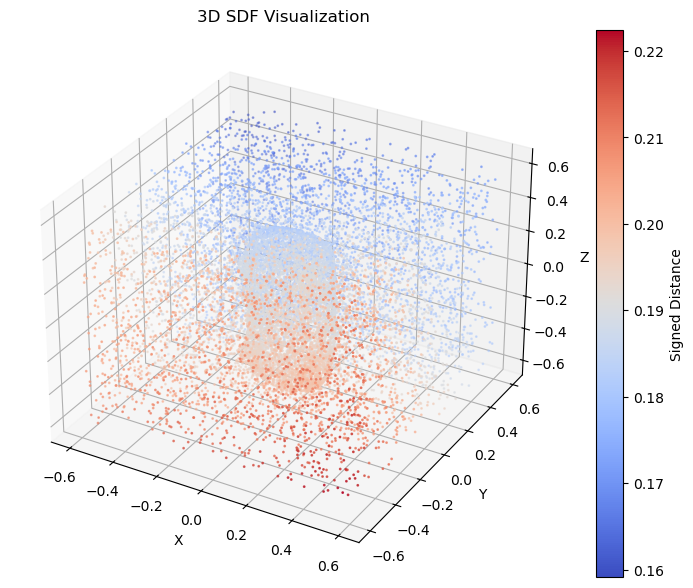

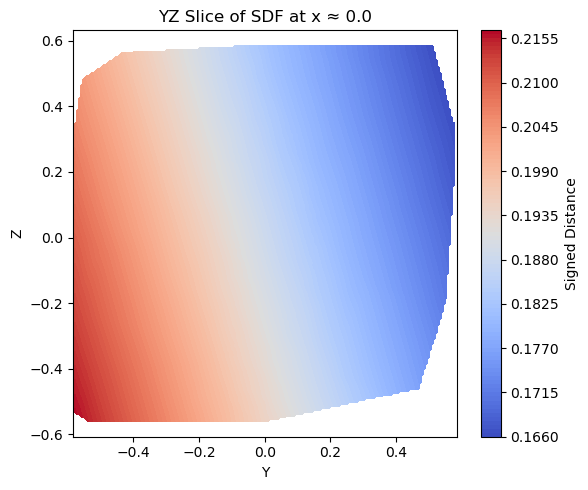

TRUTH


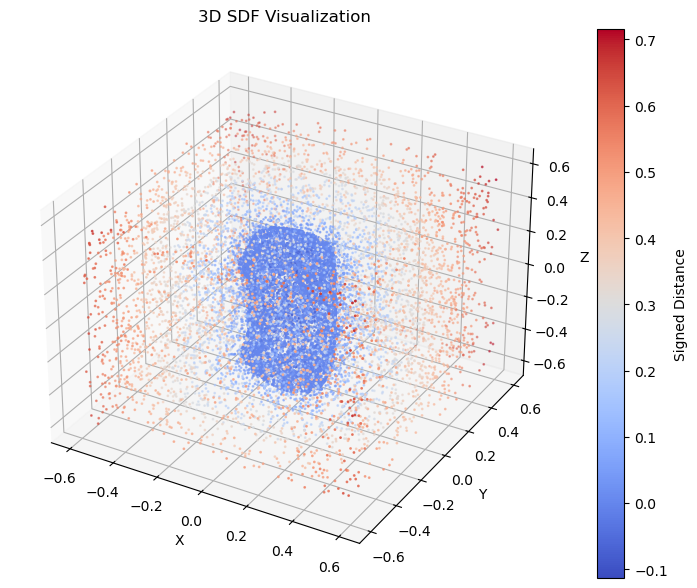

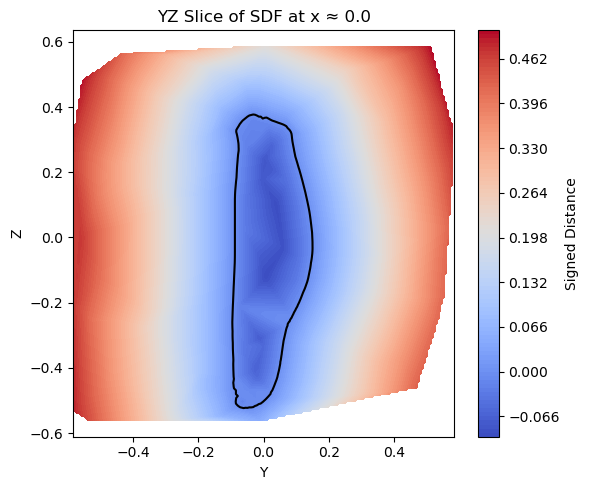

 10%|█         | 100/1000 [01:54<27:25,  1.83s/it]

Validation Loss: 0.0397


 12%|█▏        | 120/1000 [02:21<18:09,  1.24s/it]

Loss: 0.0407


 14%|█▍        | 140/1000 [02:50<18:39,  1.30s/it]

Loss: 0.0381


 16%|█▌        | 160/1000 [03:16<17:35,  1.26s/it]

Loss: 0.0406


 18%|█▊        | 180/1000 [03:47<20:25,  1.49s/it]

Loss: 0.0385


 20%|█▉        | 199/1000 [04:11<17:02,  1.28s/it]

Loss: 0.0386
MODEL


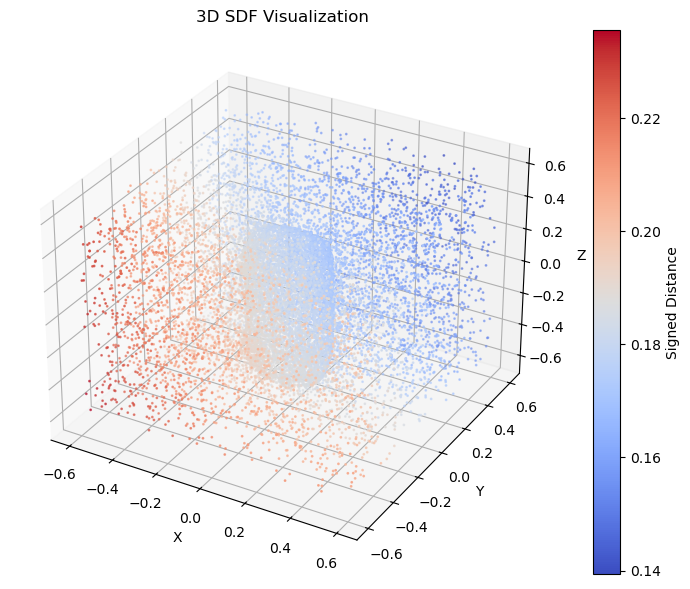

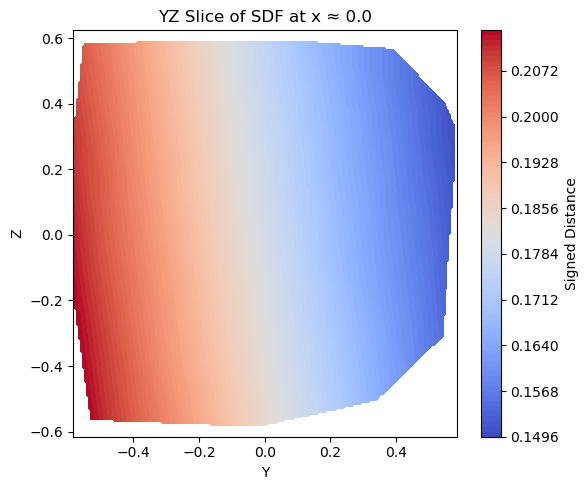

TRUTH


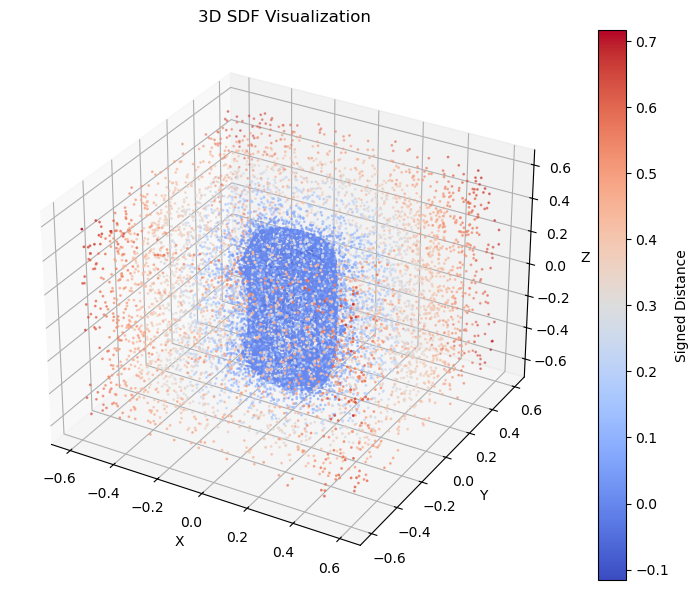

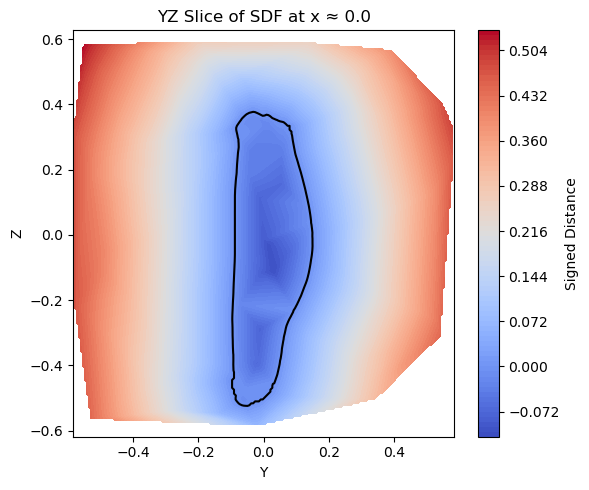

 20%|██        | 200/1000 [04:17<35:31,  2.66s/it]

Validation Loss: 0.0388


 22%|██▏       | 220/1000 [04:55<19:31,  1.50s/it]

Loss: 0.0408


 24%|██▍       | 240/1000 [05:23<18:43,  1.48s/it]

Loss: 0.0379


 26%|██▌       | 260/1000 [06:12<31:54,  2.59s/it]

Loss: 0.0378


 28%|██▊       | 280/1000 [07:01<29:38,  2.47s/it]

Loss: 0.0379


 30%|██▉       | 299/1000 [07:50<29:46,  2.55s/it]

Loss: 0.0380
MODEL


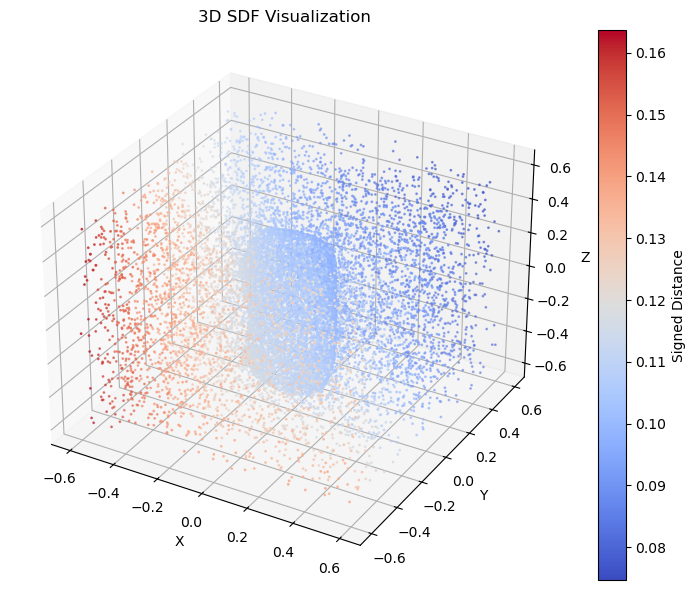

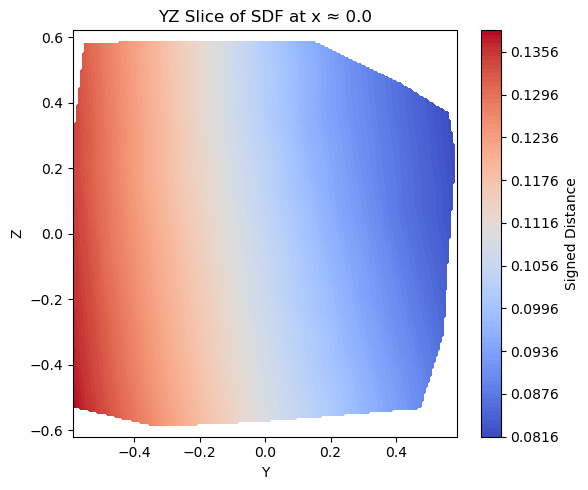

TRUTH


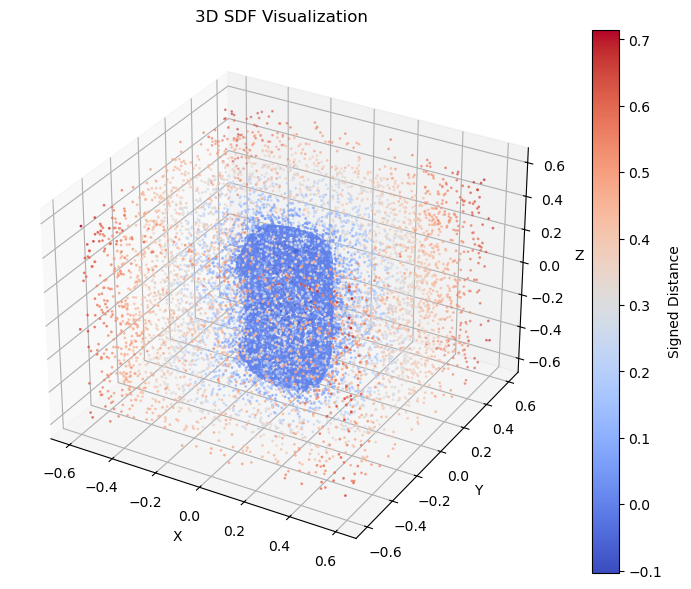

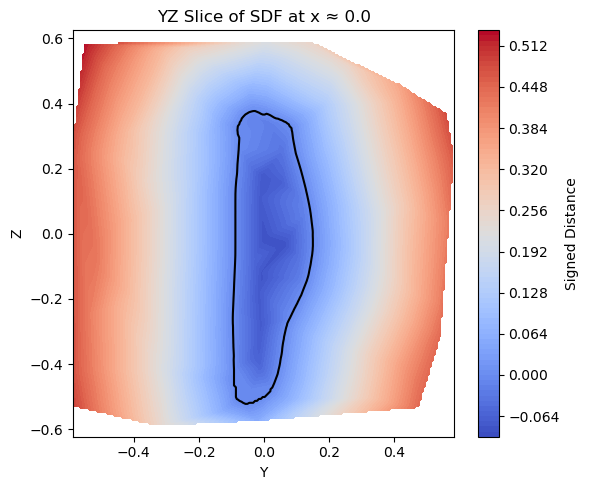

 30%|███       | 300/1000 [07:59<52:05,  4.46s/it]

Validation Loss: 0.0398


 32%|███▏      | 320/1000 [08:51<29:56,  2.64s/it]

Loss: 0.0384


 34%|███▍      | 340/1000 [09:44<29:08,  2.65s/it]

Loss: 0.0364


 36%|███▌      | 360/1000 [10:37<26:32,  2.49s/it]

Loss: 0.0353


 38%|███▊      | 380/1000 [11:47<41:38,  4.03s/it]

Loss: 0.0394


 40%|███▉      | 399/1000 [12:40<27:42,  2.77s/it]

Loss: 0.0351
MODEL


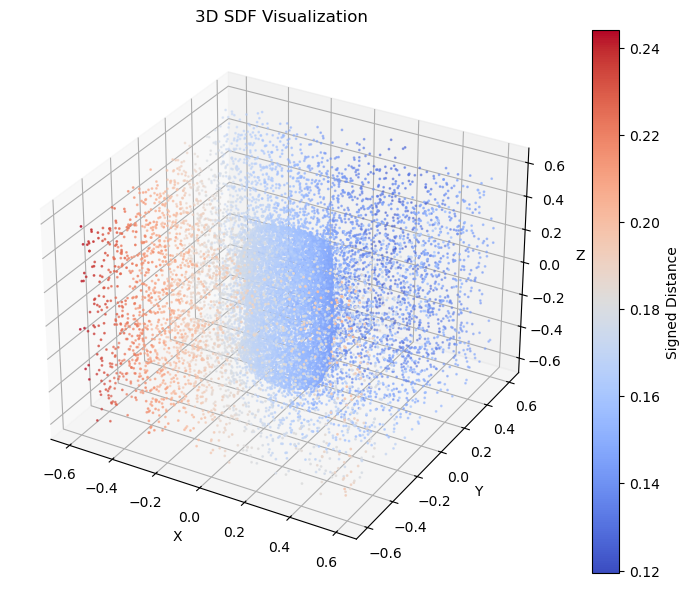

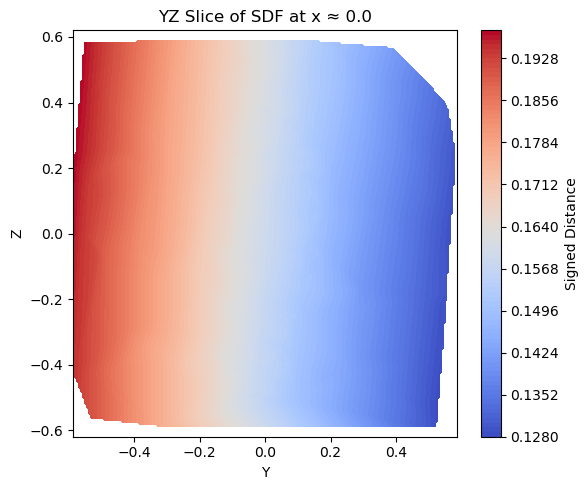

TRUTH


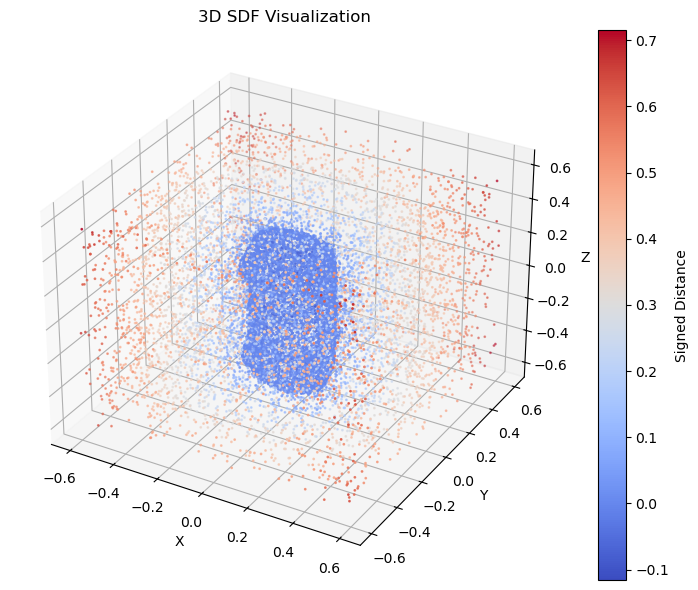

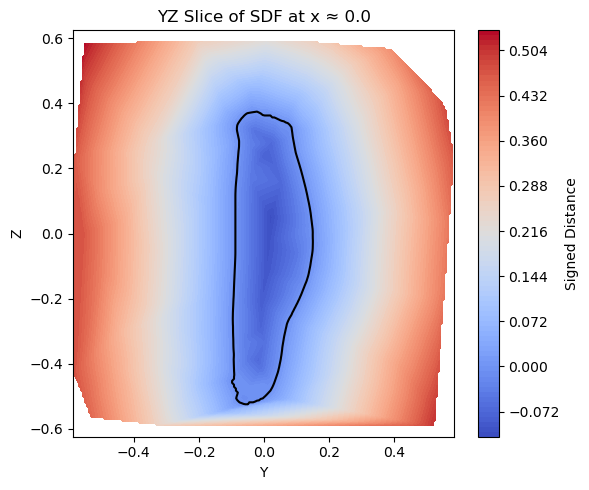

 40%|████      | 400/1000 [12:50<47:43,  4.77s/it]

Validation Loss: 0.0367


 42%|████▏     | 420/1000 [13:49<27:50,  2.88s/it]

Loss: 0.0364


 44%|████▍     | 440/1000 [14:48<27:49,  2.98s/it]

Loss: 0.0324


 46%|████▌     | 460/1000 [15:49<27:59,  3.11s/it]

Loss: 0.0387


 48%|████▊     | 480/1000 [16:48<24:11,  2.79s/it]

Loss: 0.0329


 50%|████▉     | 499/1000 [17:39<22:44,  2.72s/it]

Loss: 0.0309
MODEL


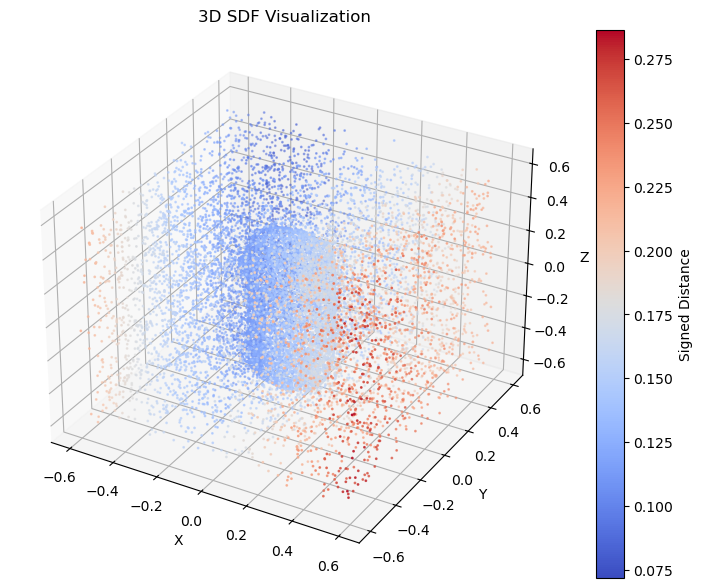

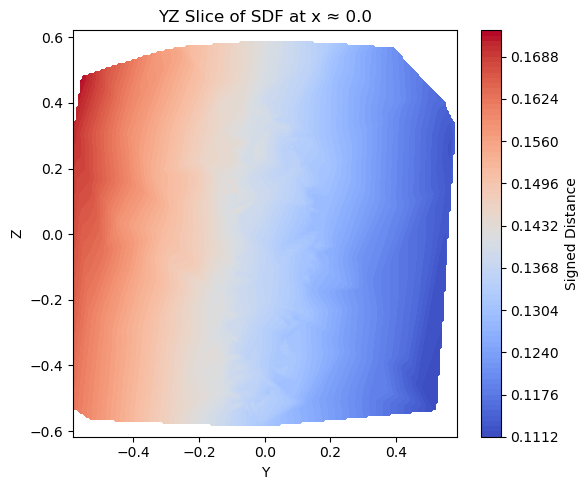

TRUTH


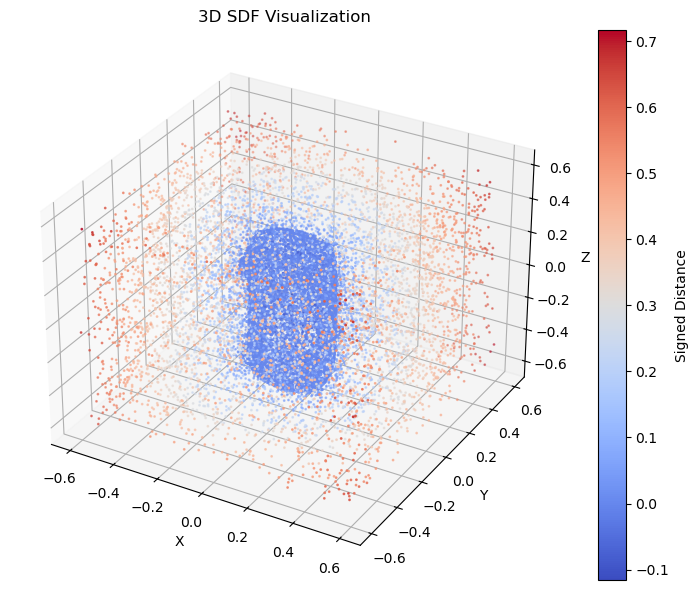

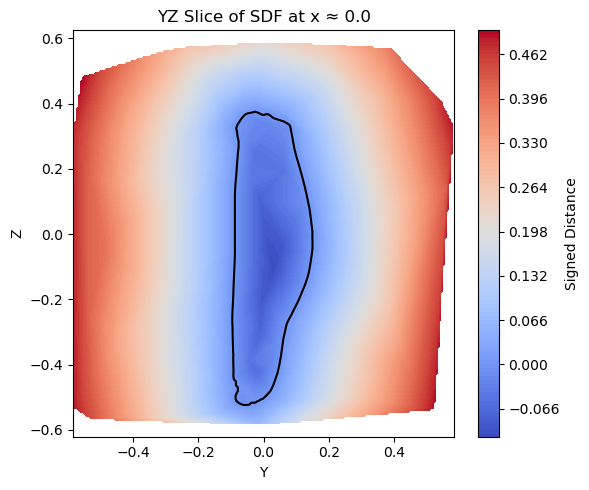

 50%|█████     | 500/1000 [17:48<37:34,  4.51s/it]

Validation Loss: 0.0349


 52%|█████▏    | 520/1000 [18:47<24:44,  3.09s/it]

Loss: 0.0319


In [ ]:
from tqdm import tqdm

EPOCHS = 1000

def train(epoch):
    model.train()
    for batch in train_loader:
        x, pos, batch, query_pos, query_sdf = process_batch(batch)
        optimizer.zero_grad()
        out, mu, logvar = model(x, pos, batch, query_pos)
        loss = loss_function(out.squeeze(-1), query_sdf, mu, logvar)  # L1 loss for SDF prediction
        loss.backward()
        optimizer.step()
    
    return loss.item()


for epoch in tqdm(range(1, EPOCHS + 1)):
    loss = train(epoch)
    if epoch % 20 == 0:
        print('Loss: {:.4f}'.format(loss))
    if epoch % 100 == 0:
        show_validation()
        # save model
        #torch.save(model.state_dict(), 'pointnet_sdf.pth')